In [161]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Gradient flow through targets of canned losses in torch.nn module

In [3]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.autograd import Variable

BATCH_SIZE = 16

criterion_mse = nn.MSELoss()
x = Variable(torch.FloatTensor( BATCH_SIZE , 10  )  )
l = nn.Linear( 10 , 10 )
y = l(x)
loss = criterion_mse( y, x )

#### Loading large csv file with pandas

In [5]:
import pandas as pd
import csv, sys

csv.field_size_limit(sys.maxsize)

131072

In [6]:
cities_df = pd.read_csv("/home/data/world-cities/cities_over_10kpop.csv", engine='python')

In [7]:
cities_df.head()

,Unnamed: 0,city,province,country,countrycode,geometry,City,area,scale,location,region,subregion,population,size
0,0,bc,ha bnh,vietnam,vnm,"POLYGON ((104.9122238159183 21.10770416259777,...","bc, ha bnh, vnm",822.327067,47.977300,POINT (105.0898583753079 20.90473936175678),Asia,South-Eastern Asia,118347.0,small-1
1,1,huoai,lm ng,vietnam,vnm,"POLYGON ((107.6680145263674 11.58079624176042,...","huoai, lm ng, vnm",496.499818,35.334831,POINT (107.6350995141158 11.43013124076439),Asia,South-Eastern Asia,83501.0,very-small
2,2,lng,ngh an,vietnam,vnm,"POLYGON ((105.3113555908204 19.02108001709013,...","lng, ngh an, vnm",354.262448,31.091116,POINT (105.3444188206974 18.89951705506391),Asia,South-Eastern Asia,315258.0,small-2
3,3,lt,lm ng,vietnam,vnm,"POLYGON ((108.4629898071291 12.00575256347656,...","lt, lm ng, vnm",394.133348,30.273768,POINT (108.4633632381151 11.92087681897704),Asia,South-Eastern Asia,25987.0,very-small
4,4,mn,cn th,vietnam,vnm,"POLYGON ((105.6183471679687 10.18791675567621,...","mn, cn th, vnm",130.334309,17.562443,POINT (105.6329062950626 10.12685462746253),Asia,South-Eastern Asia,116948.0,small-1


#### Splitting files of a directory into train, valid, test splits

In [43]:
import glob
import os
import pandas as pd
import numpy as np

In [50]:
np.random.shuffle(sample_names)

In [55]:
files = glob.glob("/home/data/world-cities/spatial-maps/samples/*")
files_df = pd.DataFrame(map(lambda f: (f,) + os.path.splitext(os.path.basename(f)), 
                 files), columns=["filename", "sample", "ext"])
files_df['sample'] = files_df['sample'].apply(lambda x: x.replace(".pickle", ""))
files_df.set_index("sample", inplace=True)
sample_names = files_df.index.unique().values
frac_train = 0.8
frac_valid = frac_test = 0.1
len_splits = [int(frac_train*len(sample_names)), int((frac_train+frac_valid)*len(sample_names))]
np.random.shuffle(sample_names)
train_idx, valid_idx, test_idx = np.split(sample_names, len_splits)


In [61]:
train_idx.shape, valid_idx.shape, test_idx.shape

((24701,), (3088,), (3088,))

In [59]:
train_files = files_df.loc[train_idx]['filename'].values
valid_files = files_df.loc[valid_idx]['filename'].values
test_files  = files_df.loc[test_idx]['filename'].values


In [60]:
len(train_files), len(valid_files), len(test_files)

(49402, 6176, 6176)

#### Operations on images

In [71]:
from PIL import Image
from scipy.ndimage.interpolation import rotate

img = np.random.random((3,3,4))
print img.shape

img_rot = rotate(img, 30, reshape=False)
print img_rot.shape

# Image.fromarray(img)

(3, 3, 4)
(3, 3, 4)


In [107]:
type(img_rot)

numpy.ndarray

#### Testing loader for DataFolder 

In [564]:
import sys
sys.path.append("/home/nbserver/BEGAN-pytorch/")
import data_loader as dl
reload(dl)

<module 'data_loader' from '/home/nbserver/BEGAN-pytorch/data_loader.pyc'>

In [600]:
loader = dl.get_loader("/home/data/world-cities/spatial-maps/", "train", 
                       32, 128, load_attributes=["region", "profiles"], rotate_angle=20)
loader = iter(loader)

Loading data from /home/data/world-cities/spatial-maps/splits/train
Found 24701 images in subfolders of: /home/data/world-cities/spatial-maps/splits/train


In [601]:
dat, atr, names = next(loader)

In [603]:
atr['profiles']['bldg'][0].size()

torch.Size([32, 97])

In [606]:
loader.dataset[0][2]

'afghanistan_alasay_very-small_41514_34.9300_69.8086'

In [558]:
import torch
import torchvision.utils as vutils
import matplotlib.pylab as plt
import matplotlib.cm as cm

def save_image_channels(tensor, filename=None, ncol=8, padding=2,
                        channel_names=None, sample_names=None, take_log=None,
                        normalize=False, range=None, scale_each=False):
    '''
    Saves individual channels of image tensor to file.
    '''
    # extract data into numpy array to manipulate
    tensor = tensor.clone().cpu()
    ncol = tensor.size()[0] if ncol is None else ncol
    t = tensor[:ncol,...]
    N, C, W, H = t.size()
    arr = t.numpy()
        
    # if log scale is requested (better visibility)
    if take_log is not None:
        for i in take_log:
            arr[:,i,...] = np.log(arr[:,i,...]+1e-4)
        arr[np.isnan(arr)] = 0
        arr[np.isneginf(arr)] = 0
        
    # scale to better visualize
    for i in np.arange(C):
        arr[:,i,...] = ((arr[:,i,...] - arr[:,i,...].min()) / (arr[:,i,...].max() - arr[:,i,...].min()) * 255).astype(np.uint8)
     
    # apply water mask
    mask = arr[:,3,...]    
    for i in np.arange(3):
        for j in np.arange(N):
            arr[j,i,...][mask[j]<128] = np.nan
        
    arr_new = arr.reshape((N*C,1,W,H), order='C')
    t1 = torch.from_numpy(arr_new)
    
    # generate grid of images using the make_grid utility in torchvision
    grid = vutils.make_grid(t1, nrow=C, padding=padding,
                            normalize=normalize, range=range, scale_each=scale_each)
    ndarr = grid.permute(1, 2, 0).numpy().transpose()[0]
    
    # generate plot & save to file
    plt.imshow(ndarr, cmap=cm.GnBu)
    if channel_names is not None:
        for i,s in enumerate(channel_names):
            plt.annotate(s, 
                         xy=(0, W/2 + i * (H+padding)), 
                         xytext=(0, W/2 + i * (H+padding)),
                         fontsize=12, color="black", weight="bold")
    
    if sample_names is not None:
        for i,s in enumerate(sample_names):
            plt.annotate(s, 
                         xy=(W/2 + i * (H+padding), 0), 
                         xytext=(W/2 + i * (H+padding), 0),
                         fontsize=12, color="blue", weight="bold")
    plt.axis("off")
    
    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)
    
    return ndarr

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


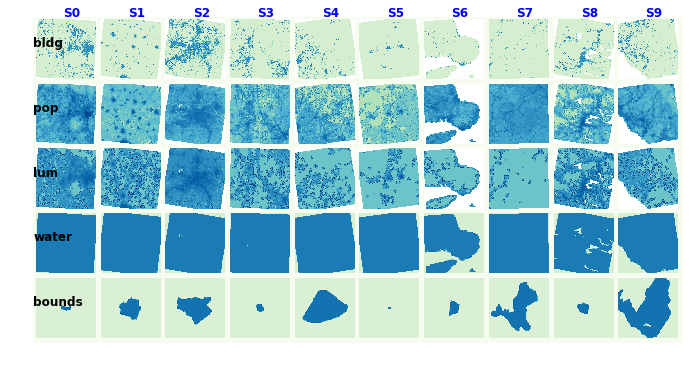

In [563]:
plt.figure(figsize=(16,6))
ndarr = save_image_channels(dat, filename="./bla.png", ncol=10, padding=10, take_log=[1,2],
                            scale_each=True,
                   channel_names=["bldg", 'pop', 'lum', 'water', 'bounds'],
                   sample_names=["S%d"%i for i in range(10)])